In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import random
from PIL import Image, ImageFile
import seaborn as sns
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files

# Tensorflow Libraries
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import Xception, MobileNetV2, ResNet50
# from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import plot_model, to_categorical

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fakhrizakiiii/face-shape-dataset-with-validation")

print("Path to dataset files:", path)

100%|██████████| 479M/479M [00:07<00:00, 68.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fakhrizakiiii/face-shape-dataset-with-validation/versions/1


In [3]:
TRAIN_DIR = os.path.join(path , 'train')
VAL_DIR = os.path.join(path , 'valid')
TEST_DIR = os.path.join(path , 'test')

In [4]:
print(os.listdir(TRAIN_DIR))

['Oblong', 'Heart', 'Oval', 'Round', 'Square']


In [5]:
# VAL_DIR = os.path.join(DATA_DIR, 'validation_set')

# if not os.path.exists(VAL_DIR):
#     os.makedirs(VAL_DIR)

# print(f"validation_set directory successully made in : {VAL_DIR}")

In [6]:
# from os.path import join

# img_folders = [join(TRAIN_DIR, folder) for folder in os.listdir(TRAIN_DIR)]
# list(img_folders)

In [7]:
#Utils

def split_data_for_validation(train_dir, val_dir, split_ratio=0.1):
    """
    Membagi data dari train_dir ke val_dir dengan split_ratio secara seimbang berdasarkan label.

    Args:
        train_dir (str): Path ke direktori data training.
        val_dir (str): Path ke direktori data validation.
        split_ratio (float): Rasio data yang akan dipindahkan ke validation.
    """
    # Membuat direktori val_dir jika belum ada
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Mendapatkan daftar subdirektori (label) dalam train_dir
    labels = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

    for label in labels:
        label_train_path = os.path.join(train_dir, label)
        label_val_path = os.path.join(val_dir, label)

        # Membuat folder label di val_dir jika belum ada
        if not os.path.exists(label_val_path):
            os.makedirs(label_val_path)

        # Mendapatkan daftar file dalam subdirektori label
        files = [f for f in os.listdir(label_train_path) if os.path.isfile(os.path.join(label_train_path, f))]

        # Mengacak file dan memilih 10% untuk validation
        random.shuffle(files)
        split_count = int(len(files) * split_ratio)
        val_files = files[:split_count]

        # Memindahkan file ke direktori val_dir
        for file in val_files:
            src_path = os.path.join(label_train_path, file)
            dest_path = os.path.join(label_val_path, file)
            shutil.move(src_path, dest_path)

        print(f"{len(val_files)} files moved from {label_train_path} to {label_val_path}")


def plot_data_distribution(train_dir, val_dir, test_dir):
    # Membuat daftar direktori dan label
    dirs = {"Train": train_dir, "Validation": val_dir, "Test": test_dir}
    data = []

    for dataset_type, dir_path in dirs.items():
        classes = [class_name for class_name in os.listdir(dir_path) if class_name != 'desktop.ini']
        for class_name in classes:
            class_path = os.path.join(dir_path, class_name)
            count = len(os.listdir(class_path))
            data.append({"Dataset": dataset_type, "Label": class_name, "Count": count})

    # Mengubah data menjadi dataframe
    import pandas as pd
    df = pd.DataFrame(data)

    # Membuat plot
    plt.figure(figsize=(14, 7))
    palette = sns.color_palette("pastel", len(df['Label'].unique()))
    ax = sns.barplot(data=df, x="Label", y="Count", hue="Dataset", palette=palette)

    # Rotasi label x-axis
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Menambahkan label jumlah di atas bar
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%d', padding=3)

    # Menambahkan grid horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Menambahkan judul dan label sumbu
    plt.title('Data Composition Across Train, Validation, and Test Sets', fontsize=18, fontweight='bold')
    plt.xlabel('Labels', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

    plt.tight_layout()
    plt.legend(title="Dataset", fontsize=12)
    plt.show()


def create_df(folder_path) :
    classes = [class_name for class_name in os.listdir(folder_path) if class_name != 'desktop.ini']

    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name)
                           for file_name in os.listdir(class_path)])

    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [8]:
# split_data_for_validation(TRAIN_DIR, VAL_DIR)

<ipython-input-7-03b37d1e64ad>:63: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.barplot(data=df, x="Label", y="Count", hue="Dataset", palette=palette)


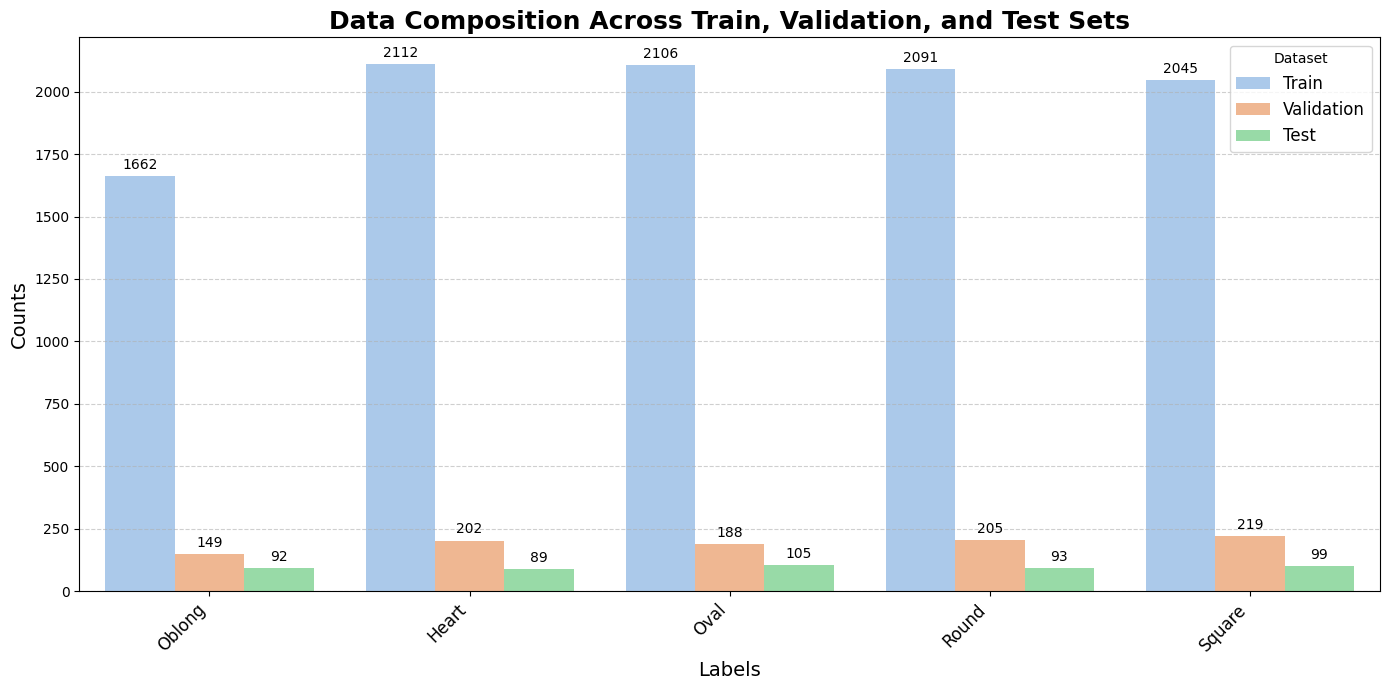

In [9]:
plot_data_distribution(TRAIN_DIR, VAL_DIR, TEST_DIR)

In [10]:
train_df = create_df(TRAIN_DIR)
val_df = create_df(VAL_DIR)
test_df = create_df(TEST_DIR)

In [11]:
print(train_df)

                                               file_path   label
0      /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
1      /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
2      /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
3      /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
4      /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
...                                                  ...     ...
10011  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10012  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10013  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10014  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
10015  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square

[10016 rows x 2 columns]


In [12]:
print(val_df)

                                             file_path   label
0    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
1    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
2    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
3    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
4    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
..                                                 ...     ...
958  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
959  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
960  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
961  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
962  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square

[963 rows x 2 columns]


In [13]:
print(test_df)

                                             file_path   label
0    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
1    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
2    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
3    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
4    /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Oblong
..                                                 ...     ...
473  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
474  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
475  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
476  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square
477  /root/.cache/kagglehub/datasets/fakhrizakiiii/...  Square

[478 rows x 2 columns]


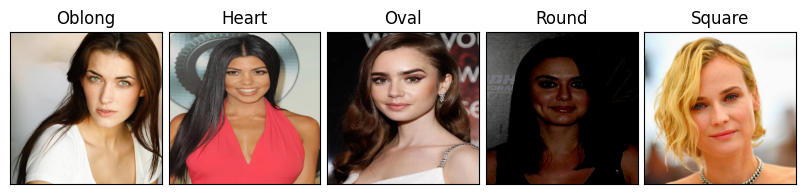

In [14]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [15]:
#Hyperparameters
image_size = (224, 224)
batch_size = 64
seed = 42
learning_rate = 0.00001

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 10016 validated image filenames belonging to 5 classes.
Found 963 validated image filenames belonging to 5 classes.
Found 478 validated image filenames belonging to 5 classes.


In [17]:
display(train_generator.class_indices)
display(val_generator.class_indices)
display(test_generator.class_indices)

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

In [18]:
# print('Loading Xception ...')
# base_model = Xception(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )
# print('Xception loaded')

# print('Loading MobileNetV2 ...')
# base_model = MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
# )
# print('MobileNetV2 loaded')

print('Loading ResNet50 ...')
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
print('ResNet50 loaded')

Loading ResNet50 ...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 loaded


In [19]:
# Name of layers in Xception
for layer in base_model.layers :
    print(layer.name)

input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

In [20]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers :
    if layer.name == 'conv5_block1_1_conv' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 15,238,917 (58.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [24]:
# Optimizer
opt = RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-08)
# opt = Adam(learning_rate=learning_rate, decay=1e-6)
# opt = SGD(learning_rate=learning_rate, momentum=0.9)

# Compilation
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model CheckPoint
checkpoint_cb = ModelCheckpoint('BestModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [25]:
epochs_0 = 50

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_0,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 175s 979ms/step - accuracy: 0.2432 - loss: 1.7293 - val_accuracy: 0.3520 - val_loss: 1.4845 - learning_rate: 1.0000e-05
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 184s 911ms/step - accuracy: 0.3448 - loss: 1.5130 - val_accuracy: 0.4216 - val_loss: 1.3891 - learning_rate: 1.0000e-05
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 149s 908ms/step - accuracy: 0.4079 - loss: 1.4079 - val_accuracy: 0.4496 - val_loss: 1.3260 - learning_rate: 1.0000e-05
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.4631 - loss: 1.3123 - val_accuracy: 0.4860 - val_loss: 1.2788 - learning_rate: 1.0000e-05
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.4930 - loss: 1.2375 - val_accuracy: 0.5088 - val_loss: 1.2230 - learning_rate: 1.0000e-05
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 201s 917ms/step - accuracy: 0.5490 - loss: 1.1370 - val_accuracy: 0.5275 - val_loss: 1.2080 - learning_rate: 1.0000e-05
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
model.save('MyModel.keras')

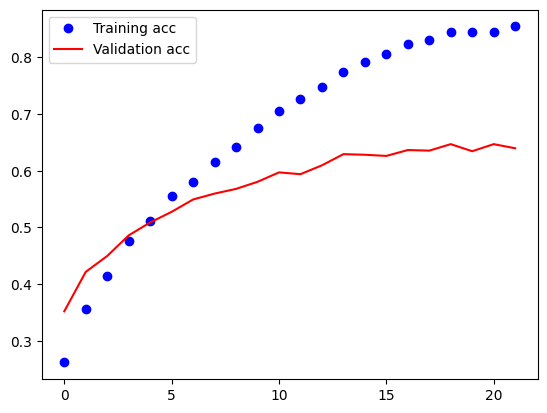

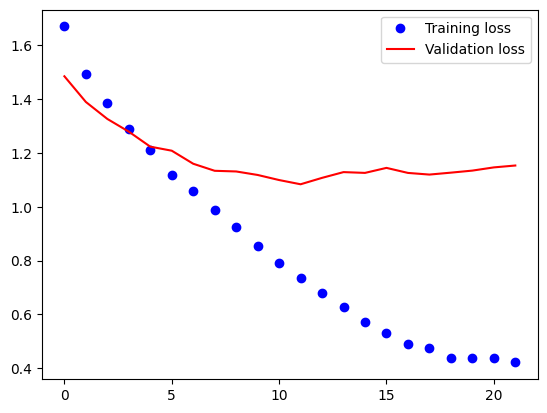

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt


epochs = range(len(acc))
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.legend()


plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')

plt.legend()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step


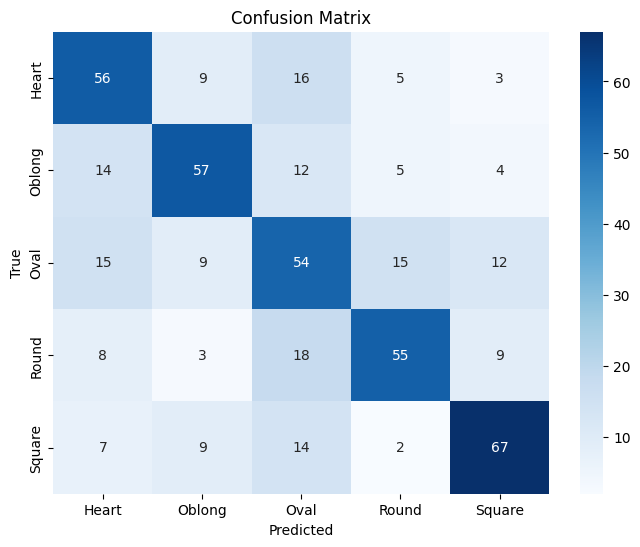

In [28]:
y_pred = model.predict(test_generator)
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()